In [1]:
import pandas as pd
import numpy as np
import networkx as nx
import csv
import random
import matplotlib.pyplot as plt
import statistics 
from scipy import stats
import io
import time#for recording time 
import sys #for getting size of object

plt.rcParams["figure.figsize"] = (10,10)



In [2]:
random.seed(10)

### *Importing files from github for google colab


In [3]:
url = 'https://raw.githubusercontent.com/sobhan-moosavi/varicella_study/main/contact_rules.csv'
rules_df  = pd.read_csv(url,header=None,engine='python')
url2='https://raw.githubusercontent.com/sobhan-moosavi/varicella_study/main/frequency_contact.csv'
frequency_df= pd.read_csv(url2,header=None,engine='python')
url3='https://raw.githubusercontent.com/sobhan-moosavi/varicella_study/main/varicella_prevalance.csv'
V_prevalence_df =pd.read_csv(url3,header=None,engine='python')
url4='https://raw.githubusercontent.com/sobhan-moosavi/varicella_study/main/population.csv'
population_df=pd.read_csv(url4,header=None,engine='python')

### *importing files from pc


# THE GRAPH CONTROL PANEL

In [4]:
N =500# Number of nodes
setting='home'    #the setting we are evaluating(home,work,school,other)
D=180#number of days the model runs
increase_ratio=100 #the rate of increasing weight per contact
lower_weight=0  #the minimum weight between two node
birth_rate=.03

## 1-Defining Nodes

In [5]:
#defining a dictionary of nodes

group_popularity = dict() #based on consensus year 95
v_prevalence=dict() #based on meta analysis(data is not exact!! update needed!!)contan(age_group,prevalance,lower CL)
nodes_dic=dict() #dictionary of nodes
frequency=dict()


for i, row in population_df.iterrows():
    group_popularity[row[0]]=float(row[1])
    
for i, row in V_prevalence_df.iterrows():
    v_prevalence[row[0]]=[float(row[1]),float(row[2])]
    

#importing data for frequency of contact in each setting for comparison
for i, row in frequency_df.iterrows():
    frequency[row[0]]=dict()
    for i in range(1,6):
        frequency[row[0]][i]=float(row[i])
                    
for i in range(N):#deciding nodes ages
    while True:
        r=random.random()
        t=random.choice(list(group_popularity.keys()))
        if r<=group_popularity[t]:
            nodes_dic[i]={'age':t}
            break


for i in range(N):  #deciding nodes seropositivity
    a=v_prevalence[nodes_dic[i]['age']][0]
    b=v_prevalence[nodes_dic[i]['age']][1]
    r=np.random.random()
    t=np.random.normal(a,(a-b)) 
    if r<=t:
        nodes_dic[i]['infection']=1
    else:
        nodes_dic[i]['infection']=0
        

### Which `group` each node belongs to?

* We  used `Age specific population for Iran` to define probability of each group

In [6]:

# the number of nodes in each group:

age_count = {}
for n in nodes_dic.keys():
    
    if nodes_dic[n]['age'] in age_count:
        age_count[nodes_dic[n]['age']] = age_count[nodes_dic[n]['age']] + 1
    else:
        age_count[nodes_dic[n]['age']] = 1
age_count

{'20_24': 37,
 '0_4': 34,
 '10_14': 32,
 '15_19': 26,
 '30_34': 51,
 '50_54': 30,
 '55_59': 17,
 '25_29': 50,
 '5_9': 57,
 '65_69': 12,
 '35_39': 37,
 '40_44': 43,
 '75+': 12,
 '45_49': 36,
 '60_64': 14,
 '70_74': 12}

## 2-Defining Connection Rules between Node Groups

### `We define rules in terms of connection probability between each two groups`


In [7]:
#importing rules from .csv to nested dictionary
rules={}  # rules contain ->{location:{contactor:{contactee:contact number}
temp_0={}
temp_1={}
location=[]
contactor=[]
contactee=[]
contact_number=[]

for i, row in rules_df.iterrows():
    
    location.append(row[0])
    contactor.append(row[1])
    contactee.append(row[2])
    contact_number.append(float(row[3]))

for o in range (0,1280,256):
    for m in range(o,o+256,16):
        for n in range (m,m+16):
            
            temp_0[contactee[n]]=contact_number[n]
        temp_1[contactor[m]]=temp_0.copy()
    rules[location[o]]=temp_1.copy()     

In [8]:
for i in rules.keys():
    print(i)
print(frequency)

all
home
others
school
work
{'home': {1: 0.7030300218, 2: 0.154702798, 3: 0.09122546518, 4: 0.03693564104, 5: 0.01410607396}, 'work': {1: 0.466152835, 2: 0.2665352214, 3: 0.103244309, 4: 0.06930752226, 5: 0.09476011233}, 'school': {1: 0.7132751188, 2: 0.2379241738, 3: 0.02564385984, 4: 0.01354040013, 5: 0.009616447441}, 'others': {1: 0.1578191805, 2: 0.3017507724, 3: 0.2328745748, 4: 0.1431825984, 5: 0.164372874}}


## 3-Defining Rules to Connecting Nodes and Adjusting `Weights`

* This would be the step that our Naive graph would evolve over the time through a simulation process
* we monitor connection between nodes and update weights based on connections

In [9]:
#in this block we've defiend a function "Run" 
def Run(increase_ratio,D,nodes_dic,age_count):
    
    #building the array based on nodes_dic
    #graph_array=[[1]*N]*N
    graph_array=[]
    for i in range(N):
        graph_array.append([])
        for j in range(N):
            graph_array[i].append(1)
      
    #counting number of each age group in graph
    group_count=age_count
    #making a dictionary that consists of lists of nodes in each age group
    nodes_age_grouped=dict() 
    
    for i in range(N):
            
        if nodes_dic[i]['age'] in nodes_age_grouped:
            
            nodes_age_grouped[nodes_dic[i]['age']].append(i)
            
        else:
            
            nodes_age_grouped[nodes_dic[i]['age']]=[i]
            
    
    #bulding zero's arrays "contacted" and contacted history for storing contacts in single day
    #contacted=[[0]*N]*N
    
    contacted=[]
    
    
    for i in range(N):
        contacted.append([])
        for j in range(N):
            contacted[i].append(0)
            
    
    
    #determinig weight factors based on age of contacor and contactee
    
    weight_factors={}
    for i in group_count.keys():
        weight_factors[i]={}
        for j in group_count.keys():
            #determinig what age groups are active in 'setting'
            if  rules[setting][i][j]!=0 :
                
                weight_factors[i][j]={}
                age_p=rules[setting][i][j]
                weight_factors[i][j]['upper_weight']=(1/age_p)*group_count[j]
                weight_factors[i][j]['increase_rate']=weight_factors[i][j]['upper_weight']/increase_ratio
                weight_factors[i][j]['N_base']=0        #nodes with minimum possible weight
                weight_factors[i][j]['N_c']=0           #number of edges with connection AND increase weight 
                weight_factors[i][j]['decrease_rate']=0 #decrease_rate
                weight_factors[i][j]['N_c_T']=0         #Number of edges that had connection
    #/////////////////////////////////////////////////
    #weight_factors_all={}
    #for i in group_count.keys():
        #weight_factors_all[i]={}
        #for j in group_count.keys():
            #determinig what age groups are active in 'setting'
            #if  rules[setting][i][j]!=0:
                #weight_factors_all[i][j]={}
                #age_p=rules[setting][i][j]
                
                #weight_factors_all[i][j]['N_base']=[]       #nodes with minimum possible weight
                #weight_factors_all[i][j]['N_c']=[]          #number of edges with connection AND increase weight 
                #weight_factors_all[i][j]['decrease_rate']=[] #decrease_rate
                #weight_factors_all[i][j]['N_c_T']=[]         #Number of edges that had connection
    
    #///////////////////////////////////////////////////////////
    
    for d in range (0,D):#we are running the model for D days
        #reseting the values each run
        for i in weight_factors.keys(): 
            for j in weight_factors[i].keys():
                 
                weight_factors[i][j]['N_c']=0    
                weight_factors[i][j]['N_c_T']=0
                weight_factors[i][j]['N_base']=0
                
        #iterating thorough the graph and storing connections in 'contacted'
                
                age_p=rules[setting][i][j]
                count_j=group_count[j]
                
                for k in nodes_age_grouped[i]:
                    for l in nodes_age_grouped[j]:
                        if k!=l:
                            
                            r=random.random()
                            if (age_p/count_j)*graph_array[k][l] > r :
                                contacted[k][l]=1
                                weight_factors[i][j]['N_c_T']+=1
                            else:
                                contacted[k][l]=0
                               
        # iterating thorough 'contacted' and adding to the weights based on it
        
                upper_weight=weight_factors[i][j]['upper_weight']
                increase_rate=weight_factors[i][j]['increase_rate']
                decrease_rate=weight_factors[i][j]['decrease_rate']
                
                for k in nodes_age_grouped[i]:
                    for l in nodes_age_grouped[j]:
                        if k!=l:
                            #we don't want the weight to be more than 'upper weight'
                            if contacted[k][l]==1 and (graph_array[k][l]+increase_rate ) <=upper_weight:
                                graph_array[k][l]+=increase_rate
                                weight_factors[i][j]['N_c']+=1
                                   
                            if graph_array[k][l]-decrease_rate < lower_weight:
                                weight_factors[i][j]['N_base']+=1
         
        #we calculate how much weight is added overall,and then distrubt it between all nodes that should decrease weight
        
                N_base= weight_factors[i][j]['N_base']
                N_c=weight_factors[i][j]['N_c']
                N_c_T=weight_factors[i][j]['N_c_T']

                #pop is the number of nodes that will have weigh increase
                pop=(group_count[j]*group_count[i]) -N_c_T -N_base



                if pop != 0:
                    weight_factors[i][j]['decrease_rate']=(increase_rate*N_c)/pop

                else:
                    weight_factors[i][j]['decrease_rate']=0

                 #////////////////////////
                #weight_factors_all[i][j]['N_base'].append(N_base)       
                #weight_factors_all[i][j]['N_c'].append(N_c)           
                #weight_factors_all[i][j]['decrease_rate'].append(weight_factors[i][j]['decrease_rate']) 
                #weight_factors_all[i][j]['N_c_T'].append(N_c_T)

                #///////////////////////////

                for k in nodes_age_grouped[i]:
                    for l in nodes_age_grouped[j]:
                        if k!=l:
                            #we don't want the weight to be lower than lower_weight
                            if contacted[k][l]==0 and graph_array[k][l]-weight_factors[i][j]['decrease_rate'] >=lower_weight:
                                graph_array[k][l]-=weight_factors[i][j]['decrease_rate']

                                    
                        
                        
                    
            
    results={'graph_array':graph_array,'weight_factors':weight_factors,'nodes_age_grouped':nodes_age_grouped}                           
    return(results)


In [10]:
#this defines a function for aging the graph
def G_age(nodes_dict,graph_dict):
    return()
    

In [11]:
#Run_S runs the model and stores conections but do not change the weights
def Run_S (nodes_dic,graph_array,N_day,rules,age_count,N):
    connections=[]
    for i in range(N):
        connections.append([])
        for j in range(N):
            connections[i].append([])
            
    for d in range(N_day):
        for i in range(N):
            for j in range(N):
                if i!=j and 0 < rules[setting][nodes_dic[i]['age']][nodes_dic[j]['age']]:
                    
                    r=random.random()
                    age_p=rules[setting][nodes_dic[i]['age']][nodes_dic[j]['age']]
                    
                    if (age_p/age_count[nodes_dic[j]['age']])*graph_array[i][j]>r:
                        
                        connections[i][j].append(1)
                    else:
                        connections[i][j].append(0)
                    
    return(connections)

# 4- Monitroing the graph
### we monitor the graph for age specific number of contact per day and frequeny of contact

In [12]:
#this function returns p_value wilcoxon for comparison age stratified number of contacts 
 #And the mean of absoloute error for age stratified number of contact divided by age stratified number of contact

def Metric_W(results,age_count,rules) :   

    
    graph_array=results['graph_array']
    group_count=age_count

    L1=[]
    L2=[]
    L3=[]
    

    rules_m=dict()
    rules_m[setting]=dict()

    for i in rules[setting].keys():
        rules_m[setting][i]=dict()
        for j in rules[setting][i].keys():
             rules_m[setting][i][j]=0

    for i in range(N):
            for j in range(N):
                if i!=j and rules[setting][nodes_dic[i]['age']][nodes_dic[j]["age"]]!=0 :  
        
                    age_p=rules[setting][nodes_dic[i]['age']][nodes_dic[j]["age"]]
                    t=(age_p/(group_count[nodes_dic[j]['age']]*group_count[nodes_dic[i]['age']]))*graph_array[i][j]
                    rules_m[setting][nodes_dic[i]['age']][nodes_dic[j]['age']]+=t
       
            
   
    for i in rules_m[setting].keys():
        for j in rules_m[setting][i].keys():
            
            L1.append(rules[setting][i][j])
            L2.append(rules_m[setting][i][j])
            if rules[setting][i][j]!=0:
                L3.append(abs((rules_m[setting][i][j])-(rules[setting][i][j]))/rules[setting][i][j])
            else:
                L3.append(0)
    I=stats.wilcoxon(L1,L2, zero_method='wilcox', correction=False, alternative='two-sided')
    I2=statistics.mean(L3)
    
    Metric_W ={'wilx':I,'M_Abs':I2,'rules_m':rules_m,'L3':L3}
    
    return(Metric_W)

In [13]:
#defining a function that returns mean absoloute error 'frequency of contacts ' in the last x day of model
def metric_F(connections,results,age_count):
    
    n=0
    
    graph_array=results['graph_array']
    
    L1=[]
    L2=[]
    
    frequency_m=dict()
    for i in frequency.keys():
        frequency_m[i]={1:0,2:0,3:0,4:0,5:0}

    for i in range(N):
            for j in range(N):
                if i != j and connections[i][j]==[1]:
                

                    age_p=rules[setting][nodes_dic[i]['age']][nodes_dic[j]["age"]]

                    t=(age_p/age_count[nodes_dic[j]['age']])*graph_array[i][j]

                    n+=1

                    if t<(1/30) and t>(1/365) :
                        frequency_m[setting][4]+=1
                        
                    elif t <= (1/365):
                        frequency_m[setting][5]+=1

                    elif t>=(1/30) and t<=(2/30):
                        frequency_m[setting][3]+=1

                    elif t>=(1/7) and t <=(2/7):
                        frequency_m[setting][2]+=1

                    elif  t>(4/7):

                        frequency_m[setting][1]+=1
                    

    for i in frequency_m[setting].keys():
        if n!=0:
        
            frequency_m[setting][i]=frequency_m[setting][i]/n
        if n==0:
            
            frequency_m[setting][i]=0
        
            
        
    
    for i in frequency_m[setting].keys():
        
        L1.append(frequency[setting][i])
        L2.append(frequency_m[setting][i])
    
    #print('for the first time:',frequency_m[setting][5],'\nless than once a month:',frequency_m[setting][4],'\nabout once or twice a month:',frequency_m[setting][3],'\nabout once or twice a week',frequency_m[setting][2],'\ndaily or almost daily',frequency_m[setting][1])

    return(frequency_m)

In [14]:
start = time.time()

# evaluating results
### this part of code evaluates results of  function Run for the inputs

###### Run -> input : increase_ratio,D,nodes_dic
###### Run -> output : contacted_all, G, weight_all, group_count


In [15]:
#this part runs the model
results=Run(increase_ratio,D,nodes_dic,age_count)


In [16]:
end=time.time()

In [17]:
#this part returns the absoloute error for age stratified number of contact
Metr_W=Metric_W(results,age_count,rules)



In [18]:
#this part shows number of age stratified contact from data and model for comparision
t=0
L3=Metr_W['L3']
print('age i','  age j','    rules_m',  '       rules','    Abs_error')
for i in rules[setting].keys():
    
    for j in rules[setting][i].keys():
        
        model=Metr_W["rules_m"][setting][i][j]
        data=rules[setting][i][j]
        
        print(i,'->',j,"||",model,'|||',data,"||",L3[t])
        t+=1
       
        


age i   age j     rules_m        rules     Abs_error
0_4 -> 0_4 || 0.4691837599037488 ||| 0.43913 || 0.06843932298806447
0_4 -> 5_9 || 0.7001979063161797 ||| 0.70013 || 9.699101049762186e-05
0_4 -> 10_14 || 0.45338204378084523 ||| 0.45382 || 0.0009650438921924266
0_4 -> 15_19 || 0.2500784517022694 ||| 0.25108 || 0.003988960879921287
0_4 -> 20_24 || 0.4170302281689862 ||| 0.41814 || 0.002654067611359341
0_4 -> 25_29 || 0.5889218795469985 ||| 0.58958 || 0.0011162530157086562
0_4 -> 30_34 || 0.5627321567253978 ||| 0.56166 || 0.0019089070352129982
0_4 -> 35_39 || 0.44474997508439246 ||| 0.44455 || 0.0004498371035709287
0_4 -> 40_44 || 0.24257697559591693 ||| 0.24272 || 0.0005892567735788735
0_4 -> 45_49 || 0.1227609782826394 ||| 0.12269 || 0.0005785172600815975
0_4 -> 50_54 || 0.14754948061220574 ||| 0.1481 || 0.003717213962149009
0_4 -> 55_59 || 0.13726228563309678 ||| 0.13615 || 0.008169560287159662
0_4 -> 60_64 || 0.09265255271597836 ||| 0.08664 || 0.0693969611724188
0_4 -> 65_69 || 0.0

In [19]:
#this part returns p_value wilcoxon for comparison age stratified number of contacts 

print('p-value wilcoxon :','%f' % Metr_W['wilx'][1])

print('mean absoloute error : ', Metr_W['M_Abs'])

p-value wilcoxon : 0.000000
mean absoloute error :  0.12715129973519465


In [20]:
#this shows the mean of all edeges across the graph(it's supposed to stay close to one)
mean_weights=[]
for i in range(N):
    for j in range(N):
        if i != j : 
             
            mean_weights.append(results['graph_array'][i][j])
            
print(statistics.mean(mean_weights))

1.0590591591972394


home : 1 // 0.0 // 0.7030300218
home : 2 // 0.2470703125 // 0.154702798
home : 3 // 0.189453125 // 0.09122546518
home : 4 // 0.13427734375 // 0.03693564104
home : 5 // 0.00537109375 // 0.01410607396


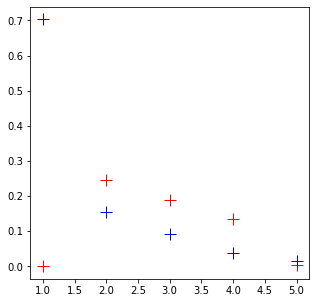

In [21]:
#this shows the fitting for frequency
connections=Run_S(nodes_dic,results['graph_array'],1,rules,age_count,N)

results_F=metric_F(connections,results,age_count)

plt.rcParams["figure.figsize"] = (5,5)

for i in results_F[setting].keys():
    print (setting,':',i,'//',results_F[setting][i],'//',frequency[setting][i])
    plt.plot(i,results_F[setting][i],'+r',linewidth=1, markersize=12,alpha=1)
    plt.plot(i,frequency[setting][i],'+b',linewidth=1, markersize=12,alpha=1)

plt.show()


In [22]:
def weight_m(results,age_count) :   

    
    graph_array=results['graph_array']
    
    
    weight_m=dict()
    

    for i in rules[setting].keys():
        weight_m[i]=dict()
        for j in rules[setting][i].keys():
             weight_m[i][j]=0
    
    for i in range(N):
            for j in range(N):
                if i!=j:
                    a=age_count[nodes_dic[i]['age']]
                    b=age_count[nodes_dic[j]['age']]
                    weight_m[nodes_dic[i]['age']][nodes_dic[j]['age']]+= graph_array[i][j]/(a*b)
    
    return(weight_m)
                
    
    

In [23]:
W=weight_m(results,age_count)

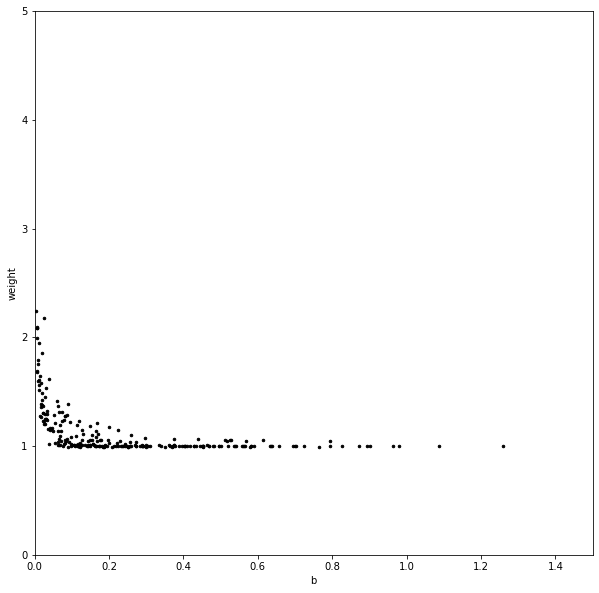

In [24]:
#this figure shows evoloution of weights thorough time
plt.rcParams["figure.figsize"] = (10,10)

for i in W.keys():
    for j in W[i].keys():
        if rules[setting][i][j] > 0:
            b=rules[setting][i][j]
            a=age_count[i]
            c=(1/rules[setting][i][j])*age_count[j]  #upper weight  
            #b=age_count[j]
            plt.plot(b,W[i][j],'k.',linewidth=.5, markersize=5,alpha=1)
            plt.plot(b,c,'r.',linewidth=.5, markersize=5,alpha=1)
        
plt.xlabel("b")
plt.ylabel('weight')
plt.axis([0,1.5,0,5])
plt.show()



In [25]:
print(end-start)

38.357730865478516


In [26]:
sys.getsizeof(results['graph_array'])

4264